In [1]:
import tensorflow as tf
tf.__version__

'2.6.0'

In [2]:
import tensorflow_datasets as tfds
tfds.disable_progress_bar()
tfds

<module 'tensorflow_datasets' from 'c:\\Users\\GuilhermeGaigherNett\\Documents\\3_envs\\tf\\lib\\site-packages\\tensorflow_datasets\\__init__.py'>

In [3]:
import numpy as np
import matplotlib.pyplot as plt

In [4]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

In [5]:
dataset, metadata = tfds.load('fashion_mnist', as_supervised=True, with_info=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

class_names = metadata.features['label'].names
print("Class names: {}".format(class_names))

Class names: ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']


In [6]:
def normalize(images, labels):
    images = tf.cast(images, tf.float32)
    images /= 255
    return images, labels

train_dataset =  train_dataset.map(normalize)
test_dataset  =  test_dataset.map(normalize)

train_dataset =  train_dataset.cache()
test_dataset  =  test_dataset.cache()

In [7]:
conv = tf.keras.layers.Conv2D(
    filters=16, kernel_size=3, input_shape=(28, 28, 1),
    activation=tf.nn.relu, padding='same')

max_pool = tf.keras.layers.MaxPooling2D(
    pool_size=(2, 2), strides=2)
flatten = tf.keras.layers.Flatten()
dense_1 = tf.keras.layers.Dense(units=128, activation=tf.nn.relu)
dropout = tf.keras.layers.Dropout(rate=0.3)
output = tf.keras.layers.Dense(units=10, activation=tf.nn.softmax)
layers = [
    conv,
    max_pool,
    flatten,
    dense_1,
    dropout,
    output
]
model = tf.keras.models.Sequential(layers)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 28, 28, 16)        160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 3136)              0         
_________________________________________________________________
dense (Dense)                (None, 128)               401536    
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1290      
Total params: 402,986
Trainable params: 402,986
Non-trainable params: 0
__________________________________________________

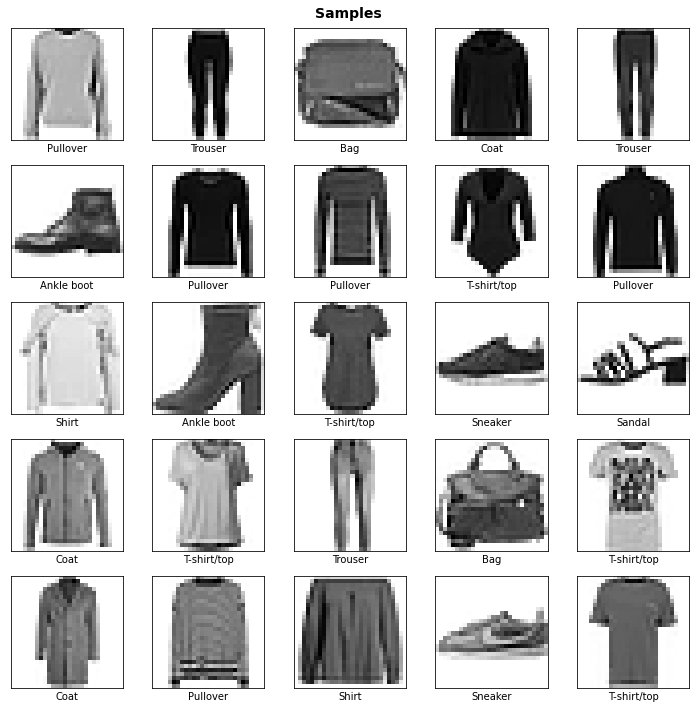

In [8]:
fig, ax = plt.subplots(5, 5, figsize=(10, 10))
ax = ax.ravel()
for i, (image, label) in enumerate(train_dataset.take(25)):
    image = image.numpy().reshape([28, 28])
    ax[i].imshow(image, cmap=plt.cm.binary)
    ax[i].set_xlabel(class_names[label])
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
plt.suptitle(f"Samples", fontweight='bold', fontsize=14)
plt.tight_layout();

## Vizualização da camada de convolução antes do treino

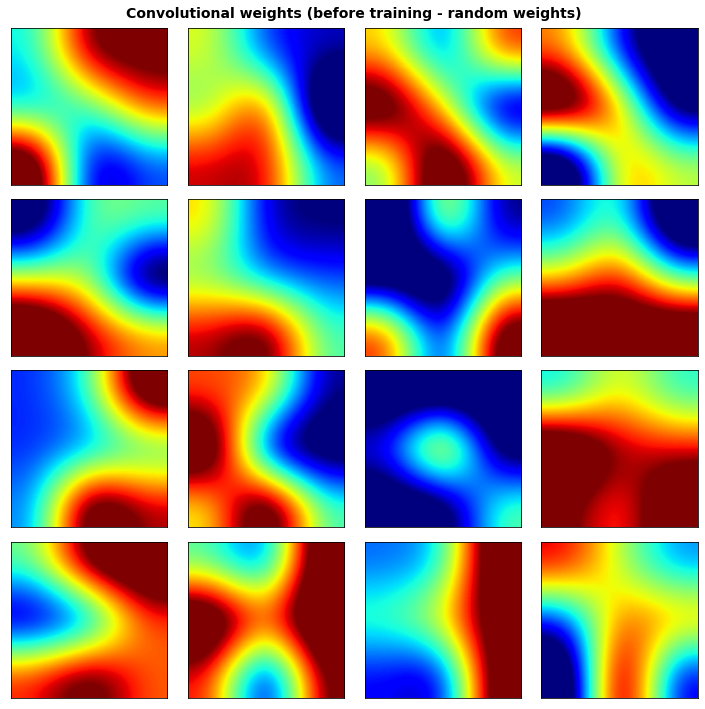

In [9]:
conv_weights = conv \
    .weights[0] \
    .numpy() \
    .squeeze(axis=2) \
    .swapaxes(0, -1)
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
ax = ax.ravel()
for i, weights in enumerate(conv_weights):
    ax[i].imshow(weights, cmap='jet', interpolation='bicubic', vmin=-.1, vmax=.1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
plt.suptitle(f"Convolutional weights (before training - random weights)", fontweight='bold', fontsize=14)
plt.tight_layout();

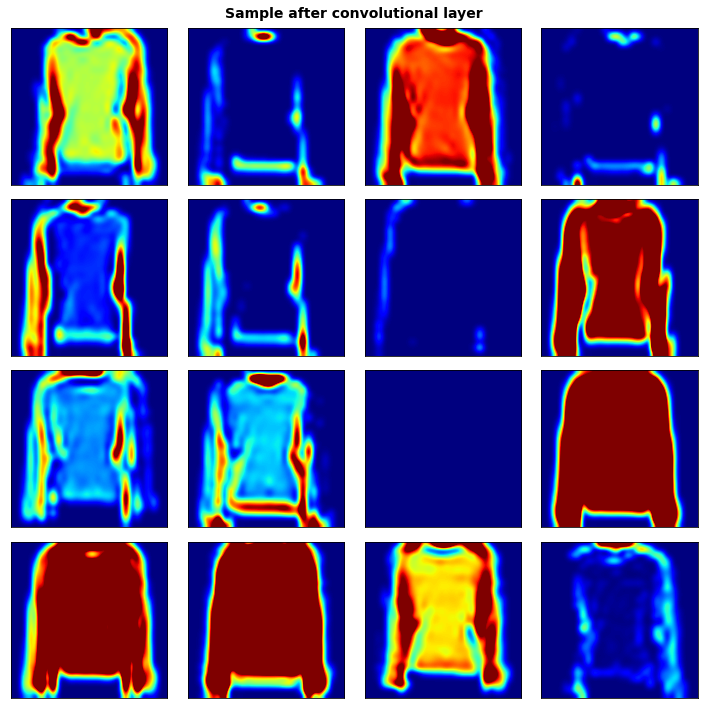

In [10]:
for image, label in train_dataset.take(1):
    image_ = image.numpy()
    pred = conv(tf.expand_dims(image_, 0))
    pred = pred \
        .numpy() \
        .swapaxes(0, -1)
    fig, ax = plt.subplots(4, 4, figsize=(10, 10))
    ax = ax.ravel()
    for i, weights in enumerate(conv_weights):
        ax[i].imshow(pred[i], cmap='jet', interpolation='bicubic', vmin=0, vmax=.1)
        ax[i].set_xticks([])
        ax[i].set_yticks([])
        ax[i].grid(False)
    plt.suptitle(f"Sample after convolutional layer", fontweight='bold', fontsize=14)
    plt.tight_layout();

In [11]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [12]:
BATCH_SIZE = 32
num_train_examples = metadata.splits['train'].num_examples
train_dataset = train_dataset.cache().repeat().shuffle(num_train_examples).batch(BATCH_SIZE)
test_dataset = test_dataset.cache().batch(BATCH_SIZE)

In [13]:
model.fit(train_dataset, epochs=10, steps_per_epoch=np.ceil(num_train_examples/BATCH_SIZE))

Epoch 1/10
1875/1875 [==============================] - 33s 16ms/step - loss: 0.4631 - accuracy: 0.8363
Epoch 2/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3142 - accuracy: 0.8861
Epoch 3/10
1875/1875 [==============================] - 28s 15ms/step - loss: 0.2719 - accuracy: 0.8995
Epoch 4/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2518 - accuracy: 0.9076
Epoch 5/10
1875/1875 [==============================] - 29s 15ms/step - loss: 0.2262 - accuracy: 0.9168
Epoch 6/10
1875/1875 [==============================] - 30s 16ms/step - loss: 0.2119 - accuracy: 0.9216
Epoch 7/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1958 - accuracy: 0.9286
Epoch 8/10
1875/1875 [==============================] - 24s 13ms/step - loss: 0.1836 - accuracy: 0.9309
Epoch 9/10
1875/1875 [==============================] - 23s 12ms/step - loss: 0.1734 - accuracy: 0.9347
Epoch 10/10
1875/1875 [==============================] - 23s 12m

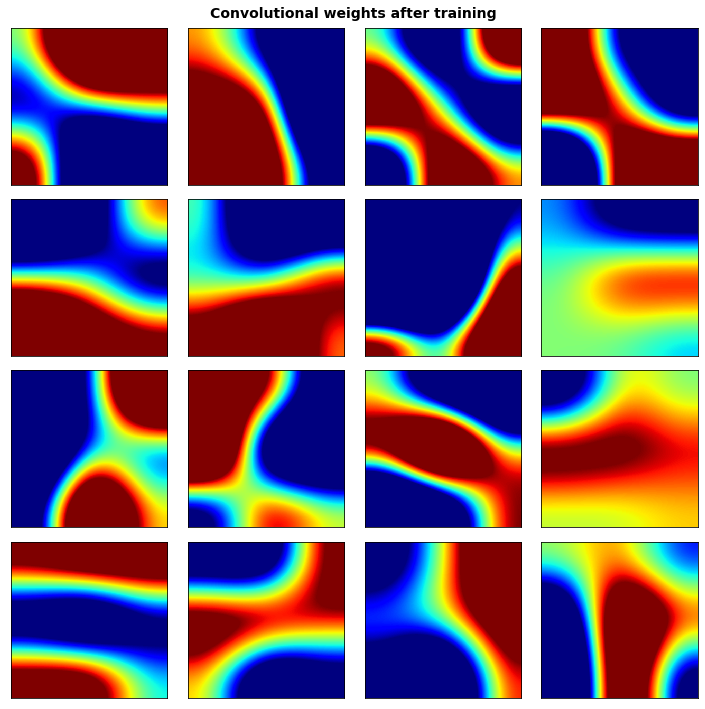

In [14]:
conv_weights = conv \
    .weights[0] \
    .numpy() \
    .squeeze(axis=2) \
    .swapaxes(0, -1)
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
ax = ax.ravel()
for i, weights in enumerate(conv_weights):
    ax[i].imshow(weights, cmap='jet', interpolation='bicubic', vmin=-.1, vmax=.1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
plt.suptitle(f"Convolutional weights after training", fontweight='bold', fontsize=14)
plt.tight_layout();

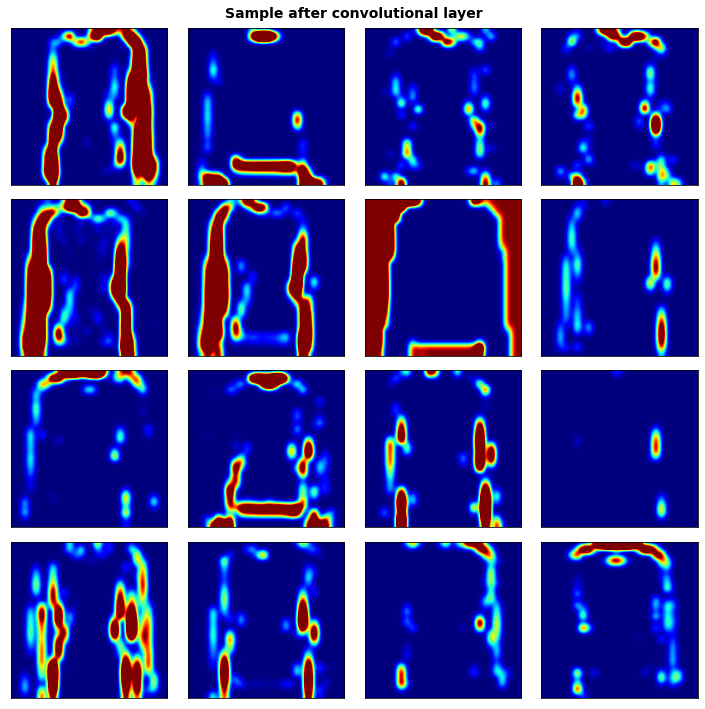

In [15]:
pred = conv(tf.expand_dims(image_, 0))
pred = pred \
    .numpy() \
    .swapaxes(0, -1)
fig, ax = plt.subplots(4, 4, figsize=(10, 10))
ax = ax.ravel()
for i, weights in enumerate(conv_weights):
    ax[i].imshow(pred[i], cmap='jet', interpolation='bicubic', vmin=0, vmax=.1)
    ax[i].set_xticks([])
    ax[i].set_yticks([])
    ax[i].grid(False)
plt.suptitle(f"Sample after convolutional layer", fontweight='bold', fontsize=14)
plt.tight_layout();